# Neural Network Implementation: simulated data, *with* test-time Dropout

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import keras
import seaborn as sns
import pymc3 as pm
plt.style.use('seaborn')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


-----

## The model:

In [69]:
# Fit model according to specification in paper
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import SGD
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import LearningRateScheduler

# Euclidean loss function--obtained from:
# http://www.riptutorial.com/keras/example/32022/euclidean-distance-loss
def euclidean_distance_loss(y_true, y_pred):
    """
    Euclidean distance loss
    https://en.wikipedia.org/wiki/Euclidean_distance
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

# Implement learning rate schedule
# Adapted from examples at https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def learning_schedule(epoch):
    base_lrate = 5e-3
    gamma = 0.0001
    p = 0.25
    lrate = base_lrate * (1 + gamma*140*epoch)**(-p)
    return lrate

# Based off of examples from:
# 1. https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
# 2. https://keras.io/getting-started/sequential-model-guide/#compilation

# Create NN dropout model
def create_model():
    # Create model
    
    # model = Sequential()
    
    # inputs
    inputs = keras.Input(shape=(1,))
    
    # Layer 1
    layer_1 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(inputs)
    dropout_1 = Dropout(0.1)(layer_1, training=True)
   
    # Layer 2
    layer_2 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_1)
    dropout_2 = Dropout(0.1)(layer_2, training=True)
   
    # Layer 3
    layer_3 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_2)
    dropout_3 = Dropout(0.1)(layer_3, training=True)
   
    # Layer 4
    layer_4 = Dense(100, kernel_initializer='lecun_uniform', activation='relu')(dropout_3)
    dropout_4 = Dropout(0.1)(layer_4, training=True)
    
    # Layer 5
    outputs = Dense(1, input_dim=24, kernel_initializer='lecun_uniform')(dropout_4)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    sgd = SGD(lr=5e-3, momentum=0.9, decay=5e-7, nesterov=False)
    model.compile(loss=euclidean_distance_loss, optimizer=sgd)
    return model

# Save predictions from every epoch
# Code from: https://stackoverflow.com/questions/36895627/python-keras-creating-a-callback-with-one-prediction-for-each-epoch?noredirect=1&lq=1


## Simulate the data: [TODO section the data off so that training for the last two segments happens far enough away from the extrema]

In [85]:
xs = np.linspace(-1, 1, 500)#*2*np.pi
#ys = xs - np.cos(xs) + np.sin(xs)
#ys = xs - np.cos(xs) + .2*np.sin(7*xs)
ys = -np.cos(xs)

#ys = np.linspace(-1, 1, 500)
#ys = np.array([1 for i in xs])

# train_mask = [False if i in range(20, 40) 
#                    or i in range(80, 100) 
#                    or i in range(130, 150)
#               else True 
#               for i in range(len(xs))]
train_mask = [False if i in range(200, 300)
              else True 
              for i in range(len(xs))]
test_mask = [not e for e in train_mask]

xs_train, ys_train = xs[train_mask], ys[train_mask]
xs_test, ys_test = xs[test_mask], ys[test_mask]

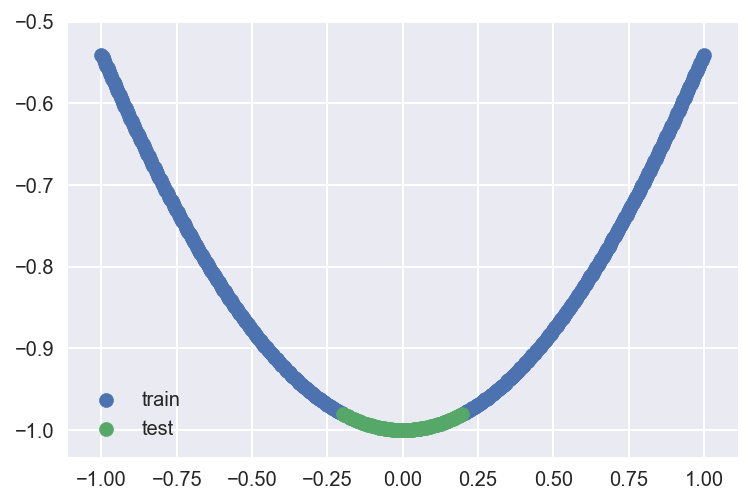

In [86]:
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.legend();

## Train the model:

In [118]:
# Code for NBatchLogger class borrowed from https://github.com/keras-team/keras/issues/2850
# from the comment by user wenmin-wu
class NBatchLogger(Callback):
    """
    A Logger that log average performance per `display` steps.
    """
    def __init__(self, display, num_xs):
        self.step = 0
        self.display = display
        self.metric_cache = {}
        self.num_xs = num_xs

    def on_batch_end(self, batch, logs={}):
        self.step += 1
        for k in self.params['metrics']:
            if k in logs:
                self.metric_cache[k] = self.metric_cache.get(k, 0) + logs[k]
        if self.step % self.display == 0:
            metrics_log = ''
            for (k, v) in self.metric_cache.items():
                val = v / self.display
                if abs(val) > 1e-3:
                    metrics_log += ' - %s: %.4f' % (k, val)
                else:
                    metrics_log += ' - %s: %.4e' % (k, val)
            print('iteration: {}... {}'.format(int(self.step/self.num_xs),
                                               metrics_log))
            self.metric_cache.clear()


# class sim_prediction_history(Callback):
#     def __init__(self):
#         self.predhis = []
#     def on_epoch_end(self, epoch, logs={}):
#         self.predhis.append(sim_model.predict(xs))


In [ ]:
nepochs = 500
# predictions=sim_prediction_history()
lrate = LearningRateScheduler(learning_schedule)
#out_batch = NBatchLogger(display=len(xs_train)*10)
# callbacks_list = [predictions, lrate, out_batch]
#callbacks_list = [lrate, out_batch]
callbacks_list = [lrate]

sim_model = create_model()
#sim_model.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=1)
sim_model.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list, verbose=1)

## Estimate uncertainty:

Here, we're computing many ($n=100$) **stochastic forward passes** through the network to get predictions

In [111]:
ys_pred = np.array([sim_model.predict(xs)[:, 0] for i in range(100)])

In [112]:
ys_pred.shape

(100, 500)

### Need to implement the methods from the paper; these estimates are just to get intutions going

In [113]:
ys_pred_mean = ys_pred.mean(axis=0)
ys_pred_sd = ys_pred.std(axis=0)

In [114]:
ys_pred_mean.shape

(500,)

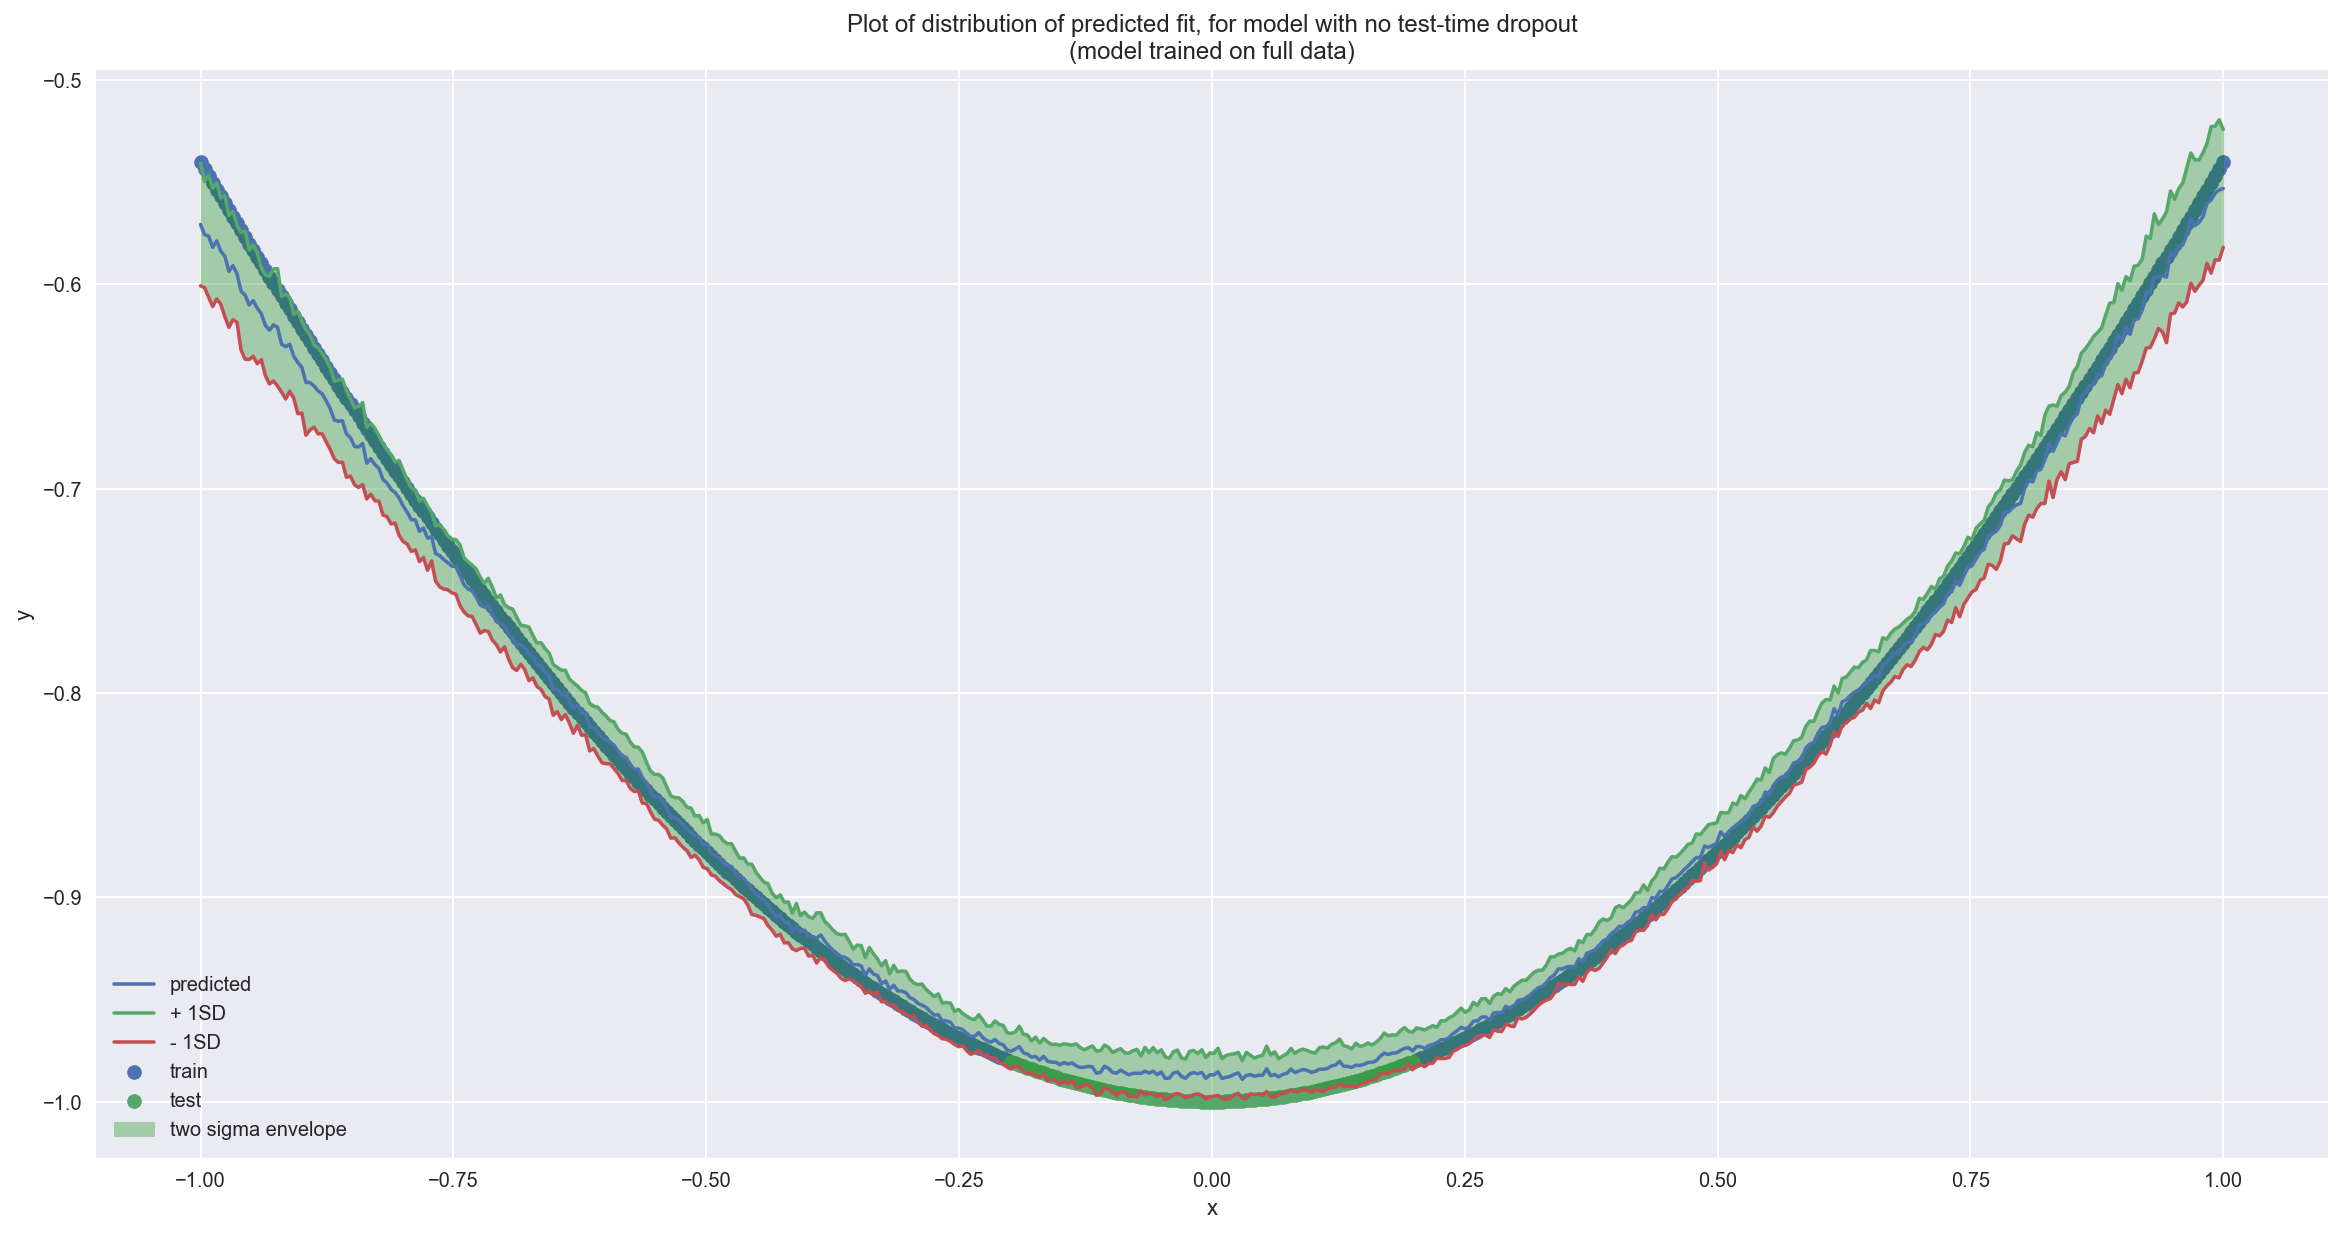

In [176]:
plt.figure(figsize=(20,10))
plt.scatter(xs_train, ys_train, label='train')
plt.scatter(xs_test, ys_test, label='test')
plt.plot(xs, ys_pred_mean, label='predicted')
plt.plot(xs, ys_pred_mean + ys_pred_sd, label='+ 1SD')
plt.plot(xs, ys_pred_mean - ys_pred_sd, label='- 1SD')
plt.fill_between(xs, ys_pred_mean - ys_pred_sd, ys_pred_mean + ys_pred_sd, color='green', alpha=0.3,
                 label="two sigma envelope")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of distribution of predicted fit, for model with no test-time dropout\n(model trained on full data)')
plt.legend()
plt.show()

------

In [178]:
def plot_nn_results(ys_mean, ys_sd, full_data):
    plt.figure(figsize=(20,10))
    plt.scatter(xs_train, ys_train, label='train')
    plt.scatter(xs_test, ys_test, label='test')
    plt.plot(xs, ys_mean, label='predicted')
    plt.plot(xs, ys_mean + ys_sd, label='+ 1SD')
    plt.plot(xs, ys_mean - ys_sd, label='- 1SD')
    plt.fill_between(xs,
                     ys_mean - ys_sd,
                     ys_mean + ys_sd, 
                     color='green', alpha=0.3, label="two sigma envelope")
    plt.xlabel('x')
    plt.ylabel('y')
    
    if full_data:
        plt.title('Plot of distribution of predicted fit, for model with no test-time dropout\n(model trained on full data)')
    
    else:
        
        plt.title('Plot of distribution of predicted fit, for model with test-time dropout\n(model trained on training data only)')

    plt.legend()
    plt.show()

## Train the models

### Full data:

In [173]:
# nepochs = 700
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs)*50, num_xs=len(xs))
# callbacks_list_dropout_full = [lrate, out_batch]

# sim_model_dropout_full = create_model()
# sim_model_dropout_full.fit(x=xs, y=ys, epochs=nepochs, batch_size=1, callbacks=callbacks_list_dropout_full, verbose=0)

iteration: 50...  - loss: 0.0426
iteration: 100...  - loss: 0.0328
iteration: 150...  - loss: 0.0294
iteration: 200...  - loss: 0.0267
iteration: 250...  - loss: 0.0256
iteration: 300...  - loss: 0.0253
iteration: 350...  - loss: 0.0233
iteration: 400...  - loss: 0.0229
iteration: 450...  - loss: 0.0224
iteration: 500...  - loss: 0.0216
iteration: 550...  - loss: 0.0211
iteration: 600...  - loss: 0.0202
iteration: 650...  - loss: 0.0199
iteration: 700...  - loss: 0.0190


In [174]:
ys_pred_dropout_full = np.array([sim_model_dropout_full.predict(xs)[:, 0] for i in range(100)])
# length scale chosen below because cosine function has a period of 2*pi
l = 2*np.pi
p = 0.25
lambda_ = 5e-7
N_full = len(xs)
tau_full = (p * l**2/(2*N_full*lambda_))

ys_pred_dropout_full_mean = ys_pred_dropout_full.mean(axis=0)
ys_pred_dropout_train_sd = np.sqrt(tau_full**(-1) + ys_pred_dropout_full.var(axis=0))

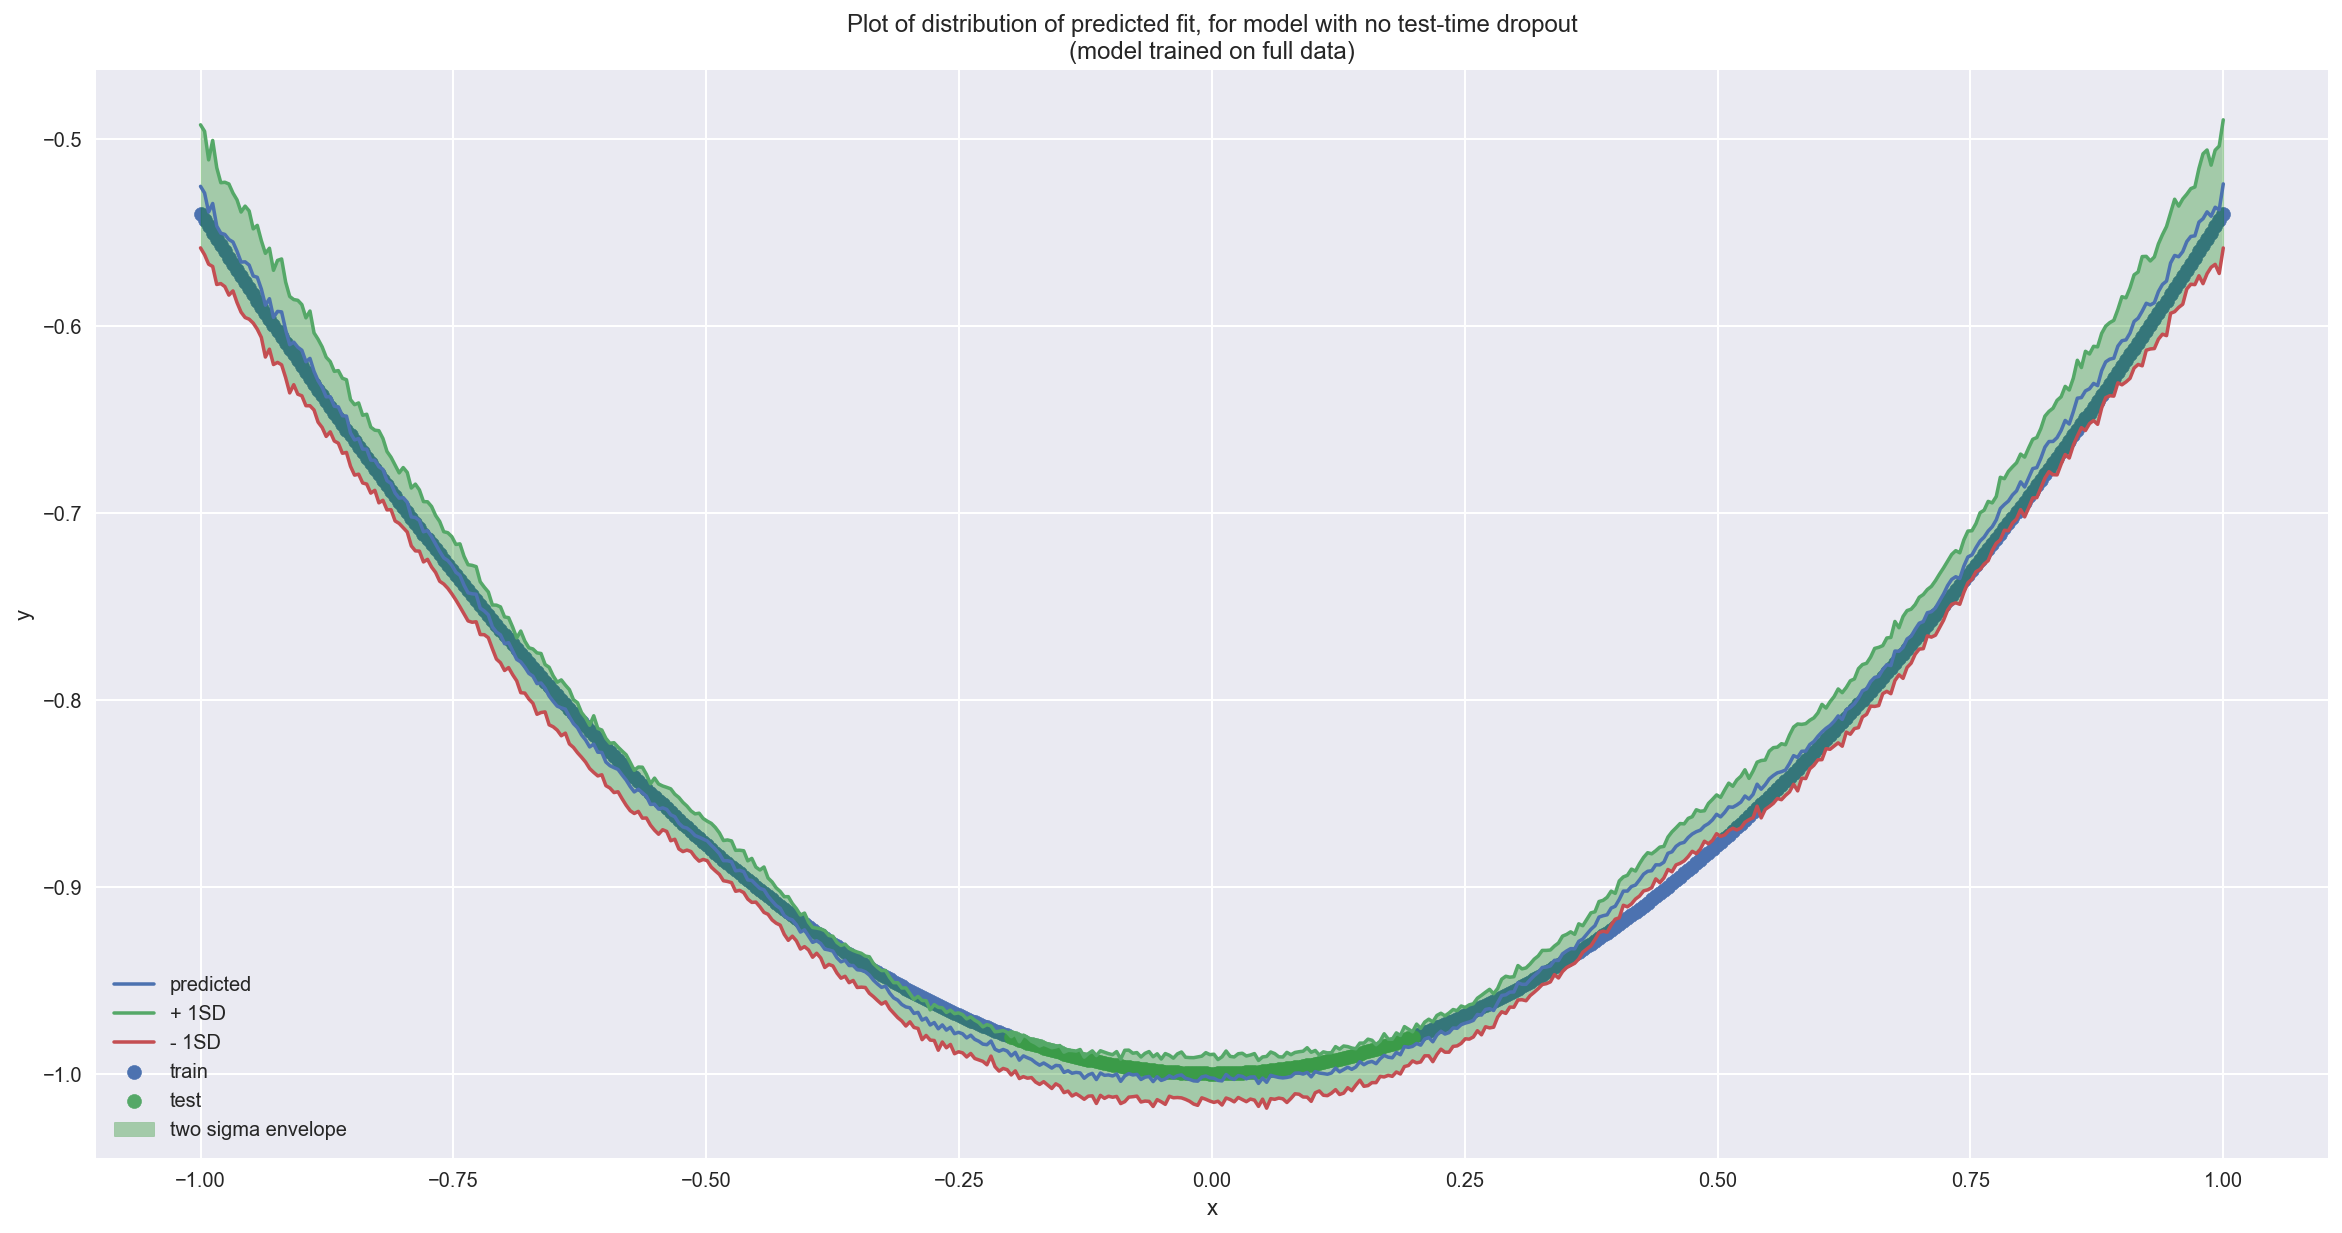

In [179]:
plot_nn_results(ys_pred_dropout_full_mean, ys_pred_dropout_full_sd, True)

# BELOW THIS LINE ARE CODE CELLS THAT SHOULD NOT BE RUN AGAIN

------

### Training data only [DO NOT RUN THESE CELLS AGAIN]

In [127]:
# nepochs = 500
# lrate = LearningRateScheduler(learning_schedule)
# out_batch = NBatchLogger(display=len(xs_train)*50, num_xs=len(xs_train))
# callbacks_list_dropout_train = [lrate, out_batch]

# sim_model_dropout_train = create_model()
# sim_model_dropout_train.fit(x=xs_train, y=ys_train, epochs=nepochs, batch_size=1,
#                             callbacks=callbacks_list_dropout_train, verbose=0)

iteration: 50...  - loss: 0.0459
iteration: 100...  - loss: 0.0336
iteration: 150...  - loss: 0.0301
iteration: 200...  - loss: 0.0280
iteration: 250...  - loss: 0.0265
iteration: 300...  - loss: 0.0250
iteration: 350...  - loss: 0.0236
iteration: 400...  - loss: 0.0226
iteration: 450...  - loss: 0.0218
iteration: 500...  - loss: 0.0212


In [168]:
ys_pred_dropout_train = np.array([sim_model_dropout_train.predict(xs)[:, 0] for i in range(100)])
# length scale chosen below because cosine function has a period of 2*pi
l = 2*np.pi
p = 0.25
lambda_ = 5e-7
N_train = len(xs_train)
tau_train = (p * l**2/(2*N_train*lambda_))

ys_pred_dropout_train_mean = ys_pred_dropout_train.mean(axis=0)
ys_pred_dropout_train_sd = np.sqrt(tau_train**(-1) + ys_pred_dropout_train.var(axis=0))

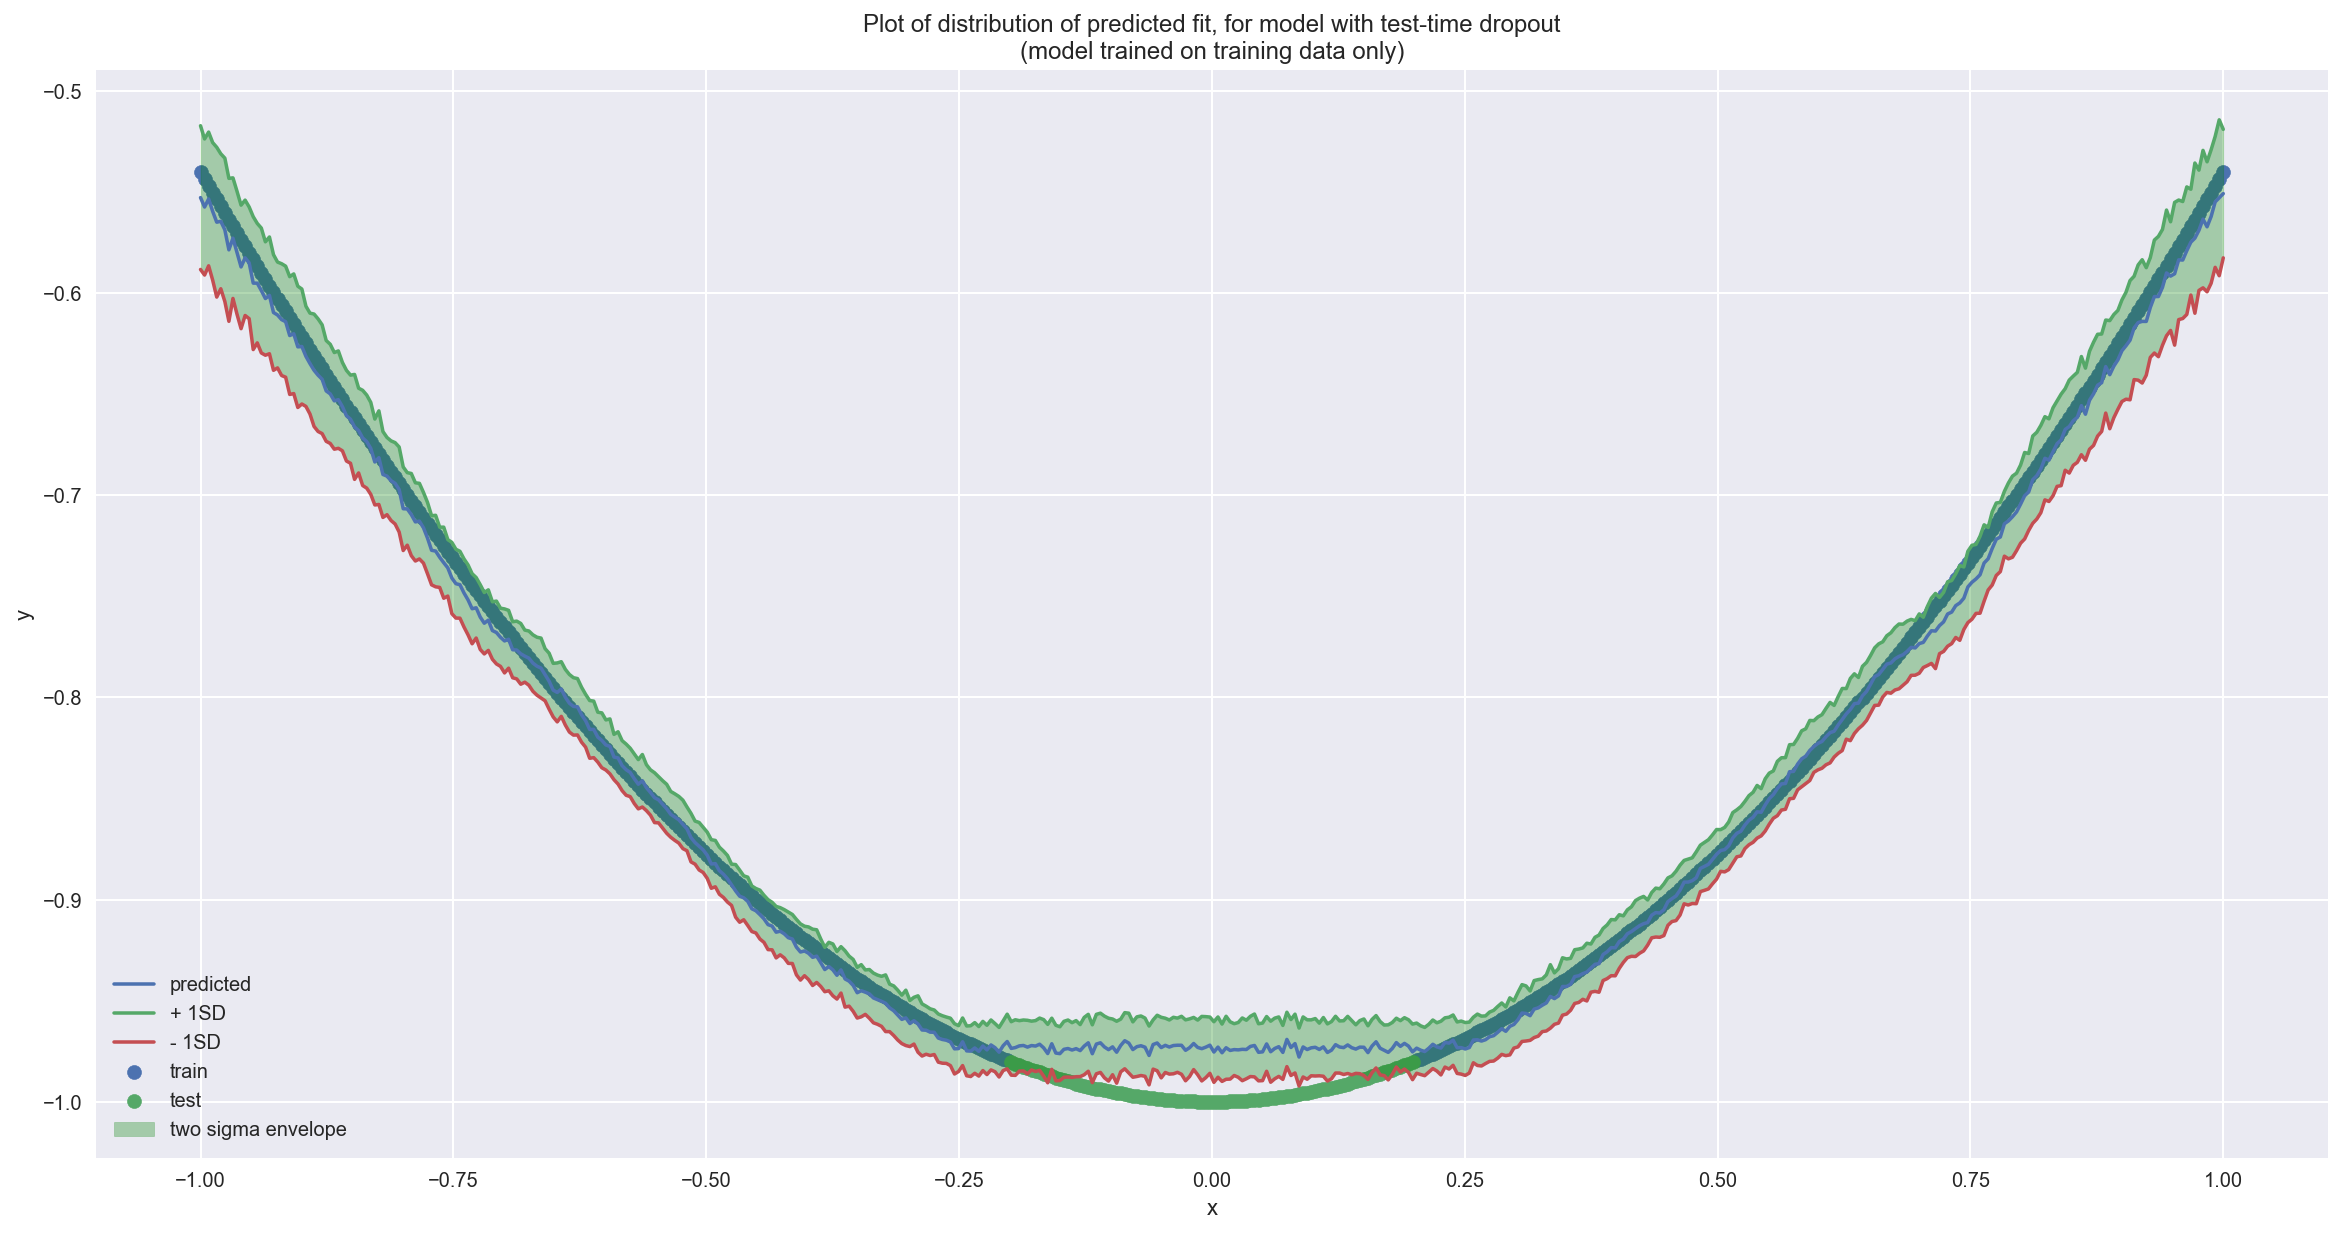

In [180]:
plot_nn_results(ys_pred_dropout_train_mean, ys_pred_dropout_train_sd, False)